# (VAD) Velocity Azimuth Display

Argonne National Laboratory

In [1]:
%%time
import warnings
warnings.filterwarnings("ignore")

from pyart.config import get_field_name
from pyart.core import HorizontalWindProfile

import tempfile, boto3, glob, netCDF4, pyart
import numpy.ma as ma
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display
from botocore.handlers import disable_signing
from siphon.simplewebservice.wyoming import WyomingUpperAir
from datetime import datetime, timedelta
from metpy.units import units
from metpy.plots import SkewT
import metpy.calc as metcalc


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119

CPU times: user 948 ms, sys: 144 ms, total: 1.09 s
Wall time: 1.11 s


In [2]:
"""
pyart.retrieve.velocity_azimuth_display
=======================================

Retrieval of VADs from a radar object.

.. autosummary::
    :toctreeL generated/
    :template: dev_template.rst

    velocity_azimuth_display
    _interval_mean
    _sd_to_uv
    _vad_calculation

"""

def _interval_mean(data, current_z, wanted_z):
    """ Find the mean of data indexed by current_z
        at wanted_z on intervals wanted_z+/- delta
        wanted_z. """
    delta = wanted_z[1] - wanted_z[0]
    pos_lower = [np.argsort((current_z - (
        wanted_z[i] - delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    pos_upper = [np.argsort((current_z - (
        wanted_z[i] + delta / 2.0))**2)[0]
                 for i in range(len(wanted_z))]
    mean_values = np.array([data[pos_lower[i]:pos_upper[i]].mean()
                            for i in range(len(pos_upper))])
    return mean_values


def _sd_to_uv(speed, direction):
    """ Takes speed and direction to create u_mean and v_mean. """
    return (np.sin(direction) * speed), (np.cos(direction) * speed)


def _vad_calculation(velocity_field, azimuth, elevation):
    """ Calculates VAD for a scan, returns speed and angle
    outdic = vad_algorithm(velocity_field, azimuth, elevation)
    velocity_field is a 2D array, azimuth is a 1D array,
    elevation is a number. All in degrees, m outdic contains
    speed and angle. """
    nrays, nbins = velocity_field.shape
    nrays2 = nrays // 2
    velocity_count = np.empty((nrays2, nbins, 2))
    velocity_count[:, :, 0] = velocity_field[0:nrays2, :]
    velocity_count[:, :, 1] = velocity_field[nrays2:, :]
    sinaz = np.sin(np.deg2rad(azimuth))
    cosaz = np.cos(np.deg2rad(azimuth))
    sumv = np.ma.sum(velocity_count, 2)
    vals = np.isnan(sumv)
    vals2 = np.vstack((vals, vals))

    # Line below needs to be changed to 'is not' expression.
    count = np.sum(np.isnan(sumv) == False, 0)

    aa = count < 8
    vals[:, aa] = 0
    vals2[:, aa] = 0
    count = np.float64(count)
    count[aa] = np.nan
    u_m = np.array([np.nansum(sumv, 0) // (2 * count)])
    count[aa] = 0

    cminusu_mcos = np.zeros((nrays, nbins))
    cminusu_msin = np.zeros((nrays, nbins))
    sincos = np.zeros((nrays, nbins))
    sin2 = np.zeros((nrays, nbins))
    cos2 = np.zeros((nrays, nbins))

    for i in range(nbins):
        cminusu_mcos[:, i] = cosaz * (velocity_field[:, i] - u_m[:, i])
        cminusu_msin[:, i] = sinaz * (velocity_field[:, i] - u_m[:, i])
        sincos[:, i] = sinaz * cosaz
        sin2[:, i] = sinaz**2
        cos2[:, i] = cosaz**2

    cminusu_mcos[vals2] = np.nan
    cminusu_msin[vals2] = np.nan
    sincos[vals2] = np.nan
    sin2[vals2] = np.nan
    cos2[vals2] = np.nan
    sumcminu_mcos = np.nansum(cminusu_mcos, 0)
    sumcminu_msin = np.nansum(cminusu_msin, 0)
    sumsincos = np.nansum(sincos, 0)
    sumsin2 = np.nansum(sin2, 0)
    sumcos2 = np.nansum(cos2, 0)
    b_value = (sumcminu_mcos - (sumsincos*sumcminu_msin / sumsin2)) / (
        sumcos2 - (sumsincos**2) / sumsin2)
    a_value = (sumcminu_msin - b_value*sumsincos) / sumsin2
    speed = np.sqrt(a_value**2 + b_value**2) / np.cos(
        np.deg2rad(elevation))
    angle = np.arctan2(a_value, b_value)
    return speed, angle


def velocity_azimuth_display(radar, vel_field=None, z_want=None,
                             gatefilter=None):
    """
    Velocity azimuth display.
    
    Creates a VAD object containing U Wind V Wind and height, that
    can then be used to plot and produces the velocity azimuth
    display.

    Parameters
    ----------
    radar : Radar
        Radar object used.
    velocity : string
        Velocity field to use for VAD calculation.

    Other Parameters
    ----------------
    z_want : array
        Heights for where to sample vads from.
        None will result in np.linespace(0, 10000, 100).
    gatefilter : GateFilter
        A GateFilter indicating radar gates that should be excluded
        from the vad calculation.

    Returns
    -------
    height : array
        Heights in meters above sea level at which horizontal winds were
        sampled.
    speed : array
        Horizontal wind speed in meters per second at each height.
    direction : array
        Horizontal wind direction in degrees at each height.
    u_wind : array
        U-wind mean in meters per second.
    v_wind : array
        V-wind mean in meters per second.

    Reference
    ---------
    Michelson, D. B., Andersson, T., Koistinen, J., Collier, C. G., Riedl, J.,
    Szturc, J., Gjertsen, U., Nielsen, A. and Overgaard, S. (2000) BALTEX Radar
    Data Centre Products and their Methodologies. In SMHI Reports. Meteorology
    and Climatology. Swedish Meteorological and Hydrological Institute, Norrkoping.

    """
    speeds = []
    angles = []
    heights = []
    z_gate_data = radar.gate_z['data']
    if z_want is None:
        z_want = np.linspace(0, 1000, 100)

    if vel_field is None:
        vel_field = get_field_name('velocity')

    if gatefilter is not None:
        velocities = np.ma.masked_where(
            gatefilter.gate_excluded,
            radar.fields[vel_field]['data'])
    else:
        velocities = radar.fields[vel_field]['data']

    for i in range(len(radar.sweep_start_ray_index['data'])):
        index_start = radar.sweep_start_ray_index['data'][i]
        index_end = radar.sweep_end_ray_index['data'][i]
        if not (index_end - index_start) % 2 == 0:
            index_end = index_end - 1

        used_velocities = velocities[index_start:index_end, :]
        azimuth = radar.azimuth['data'][index_start:index_end]
        elevation = radar.fixed_angle['data'][i]
        speed, angle = _vad_calculation(
            used_velocities, azimuth, elevation)

        print('max height', z_gate_data[index_start, :].max(),
              'meters')
        speeds.append(speed)
        angles.append(angle)
        heights.append(z_gate_data[index_start, :])

    speed_array = np.concatenate(speeds)
    angle_array = np.concatenate(angles)
    height_array = np.concatenate(heights)
    arg_order = height_array.argsort()
    speed_ordered = speed_array[arg_order]
    height_ordered = height_array[arg_order]
    angle_ordered = angle_array[arg_order]
    u_ordered, v_ordered = _sd_to_uv(speed_ordered, angle_ordered)
    u_mean = _interval_mean(u_ordered, height_ordered, z_want)
    v_mean = _interval_mean(v_ordered, height_ordered, z_want)
    vad = HorizontalWindProfile.from_u_and_v(
        z_want, u_mean, v_mean)
    return vad

In [3]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def get_radar_scan(station, desired_datetime):
    '''
    Function will pull the latest radar scan from any radar site using 
    Amazon S3.
    ----------
    station = Four letter NEXRAD identifier
              Example: 'KEPZ'
    desired_datetime = datetime string of desired date and time for a radar key
              Example: datetime(2018,8,20,0,0,0) 
    '''
    
    #creating a bucket and a client to be able to pull data from AWS and setting 
    #it as unsigned
    bucket = 'noaa-nexrad-level2'
    s3 = boto3.resource('s3')
    s3.meta.client.meta.events.register('choose-signer.s3.*', disable_signing)
    
    #connects the bucket create above with radar data
    aws_radar = s3.Bucket(bucket)
    
    #setting target string to get the key closest to desired_datetime
    target_string = datetime.strftime(desired_datetime, '%Y/%m/%d/'+station)
    my_list_of_keys = [this_object.key for this_object in aws_radar.objects.filter(Prefix= target_string)]    
    
    my_list_of_datetimes = []
    for obj in aws_radar.objects.filter(Prefix= target_string):
        try:
            my_list_of_datetimes.append(datetime.strptime(obj.key[20:35], 
                                                         '%Y%m%d_%H%M%S'))
        except ValueError:
            pass 
    my_nearest = nearest(my_list_of_datetimes, desired_datetime)
    keys = my_list_of_keys[my_list_of_datetimes.index(my_nearest)]
    print(keys)
    return aws_radar, keys

In [4]:
aws_radar, keys = get_radar_scan('KDDC', datetime(2018,8,21,0,0,0))

localfile = tempfile.NamedTemporaryFile()
aws_radar.download_file(keys, localfile.name)

2018/08/21/KDDC/KDDC20180821_000315_V06


In [5]:
radar = pyart.io.read(localfile.name)
#radar_sweep = radar.extract_sweeps([5])
#radar = pyart.io.read('/home/zsherman/dev/xsapr_sgp/data/05_19_2017/XSW170519071005.RAW54Z8')

In [6]:
radar.fields.keys()

dict_keys(['spectrum_width', 'differential_reflectivity', 'cross_correlation_ratio', 'differential_phase', 'reflectivity', 'velocity'])

In [ ]:
gatefilter = pyart.correct.GateFilter(radar)
#gatefilter.exclude_below('reflectivity', 5)
gatefilter.exclude_invalid('velocity')

In [ ]:
radar.instrument_parameters['nyquist_velocity']['data'].mean()

In [ ]:
corr_vel = pyart.correct.dealias_region_based(
    radar, vel_field='velocity', keep_original=False, 
    gatefilter=gatefilter, centered=True)
radar.add_field('corrected_velocity', corr_vel, replace_existing = True)

In [7]:
vad = pyart.retrieve.velocity_azimuth_display(radar, 'velocity', z_want=np.linspace(790, 32898, 111))

max height 16290.0 meters
max height 16312.0 meters
max height 19743.0 meters
max height 19480.0 meters
max height 16268.0 meters
max height 16312.0 meters
max height 23085.0 meters
max height 22997.0 meters
max height 27391.0 meters
max height 30773.0 meters
max height 36147.0 meters
max height 43681.0 meters
max height 52423.0 meters
max height 62338.0 meters


vad = velocity_azimuth_display(
        radar, 'velocity', z_want=np.linspace(50, 10766, 101), 
        gatefilter=gatefilter)

In [ ]:
dir(vad)

In [8]:
dataset = WyomingUpperAir.request_data(datetime(2018,8,21,0), 'DDC')

In [9]:
h = dataset['height'].values * units(dataset.units['height'])
p = dataset['pressure'].values * units(dataset.units['pressure'])
T = dataset['temperature'].values * units(dataset.units['temperature'])
Td = dataset['dewpoint'].values * units(dataset.units['dewpoint'])
u = dataset['u_wind'].values * units(dataset.units['u_wind'])
v = dataset['v_wind'].values * units(dataset.units['v_wind'])

In [10]:
print(h.shape)
print(vad.height.shape)

(111,)
(111,)


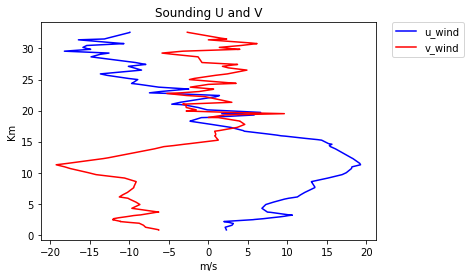

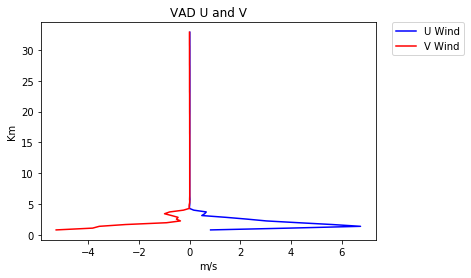

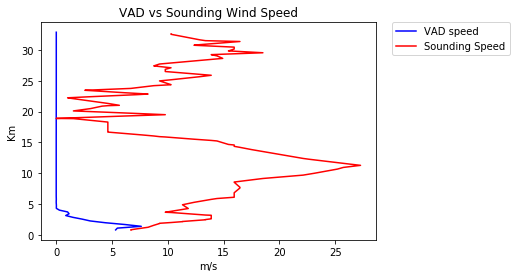

In [11]:
fig = plt.figure()
plt.plot(u*0.514444, h/1000, '-b', label='u_wind')
plt.plot(v*0.514444, h/1000, '-r', label='v_wind')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.xlim(-10,20)
#plt.ylim(0,15)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('Sounding U and V')
plt.show()

fig = plt.figure()
plt.plot(vad.u_wind, vad.height/1000, 'b-', label='U Wind')
plt.plot(vad.v_wind, vad.height/1000, 'r-', label='V Wind')
#plt.xlim(-10, 10)
#plt.ylim(0, 15)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('VAD U and V')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

fig = plt.figure()
plt.plot(vad.speed, vad.height/1000, 'b-', label='VAD speed')
plt.plot(dataset['speed']*0.514444, dataset['height']/1000, 'r-', label='Sounding Speed')
#plt.xlim(-10, 10)
#plt.ylim(0, 15)
plt.xlabel('m/s')
plt.ylabel('Km')
plt.title('VAD vs Sounding Wind Speed')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
dataset.units

In [ ]:
""" Unit Tests for Py-ART's retrieve/vad.py module. """
from numpy.testing import assert_almost_equal

In [ ]:
def test_velocity_azimuth_display():
    test_radar = pyart.testing.make_target_radar()
    height = np.arange(0, 1000, 200)
    speed = np.ones_like(height) * 5
    direction = np.array([0, 90, 180, 270, 45])
    profile = pyart.core.HorizontalWindProfile(height, speed, direction)
    sim_vel = pyart.util.simulated_vel_from_profile(test_radar, profile)
    test_radar.add_field('velocity', sim_vel,
                         replace_existing=True)

    velocity = 'velocity'
    z_want = np.linspace(0, 10, 5)

    vad_height = ([0., 2.5, 5., 7.5, 10.])
    vad_speed = ([4.98634593, 4.93978918, 4.88051406, 
                  4.81868498, 4.75765562])
    vad_direction = ([90.02444907, 90.56749781, 91.28185396, 
                      92.0561715, 92.85184062])
    u_wind = ([-4.98634547, -4.93954688, -4.87929269,
               -4.81558238, -4.75176341])
    v_wind = ([0.00212776, 0.04892636, 0.10918054,
               0.17289085, 0.23670982])

    vad = velocity_azimuth_display(
        test_radar, velocity, z_want)

    assert_almost_equal(vad.height, vad_height, 3)
    assert_almost_equal(vad.speed, vad_speed, 3)
    assert_almost_equal(vad.direction, vad_direction, 3)
    assert_almost_equal(vad.u_wind, u_wind, 3)
    assert_almost_equal(vad.v_wind, v_wind, 3)

In [ ]:
test_velocity_azimuth_display()

In [ ]:
test_radar = pyart.testing.make_target_radar()
height = np.arange(0, 1000, 200)
speed = np.ones_like(height) * 5
direction = np.array([0, 90, 180, 270, 45])
profile = pyart.core.HorizontalWindProfile(height, speed, direction)
sim_vel = pyart.util.simulated_vel_from_profile(test_radar, profile)
test_radar.add_field('velocity', sim_vel,
                     replace_existing=True)

velocity = 'velocity'
z_want = np.linspace(0, 10, 5)

vad = velocity_azimuth_display(
    test_radar, velocity, z_want)
print(vad.height)